In [16]:
# loading basic libraries which are required for most of exercises (with code)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Exercise 1

>Please return the 5 rides with the maximum time difference between the time of request and the time of completion for both London and Moscow. Please return the rides ranked by descending time difference for each city.

```
select t.row_number rank, r.ride_id, r.completed_ts-r.requested_ts diff_ts
  from (
        select r.*,
               row_number() over (order by r.completed_ts-r.requested_ts desc) as row_number,       
          from f_rides r join dim_cities c on r.city_id = c.city_id
         where c.city_name in ('London', 'Moscow')
        ) t
 where t.row_number <= 5
 order by t.row_number;
```

>Please return the week 1 retention level per city. In this context, please consider a user to be retained if the user took a ride between day 6 and day 13 (both days included) after registration.

I assume the retention per each city is calculated as the proportion $\large{\frac{\#\{\text{user | user took a ride between the days 6 and 13}\}}{\#\{\text{user | user registered between the days 0 and 6 (excl.)}\}}}$. 

In which case, the retention level per city is

```
select c.city_name, round(count(r.ride_id)/count(u.user_id),2) retention
  from dim_users u
         join dim_cities c on u.city_id = c.city_id
         left join f_rides r on u.user_id = r.user_id and u.city_id = r.city_id
 where (r.requested_ts-u.registration_is) between 6 and 13;
```

>Please return the total revenue generated by rides per city and overall for March 2019. Please note that all results need to be returned in one dataset (i.e. only with one query).

```
-- using 'with' in case of potentially complex rules for calculating the revenue
with r as
    select city_name, requested_ts, price_gbp
      from f_rides r join dim_cities c on u.ci1ty_id = c.city_id
select '2019-03' period_name, city_name, sum(price_gbp) total_price_gbp
  from r
 where r.requested_ts between to_date('2019-03-01', 'YYYY-MM-DD') and to_date('2019-04-01', 'YYYY-MM-DD')
 group by r.city_name
 union all 
select 'Grand Total' period_name, city_name, sum(price_gbp) total_price_gbp
  from r
 group by r.city_name
 order by city_name, period_name;
```

>Please return the distribution of the number of days between the first and the second
ride of users (only for users who did at least 2 rides). In other words, we want the
proportion of second ride done on the same day than the first ride, the proportion of
second rides done on the day after the first ride, etc.

```
```

```
-- getting all users with at least two rides and information of their rides no. 1 and 2 
with r12 as
    (
    select r.user_id, r.requested_ts, row_number() over (order by requested_ts asc) as ride_no
      from f_rides r 
               join 
               -- users who took at least two rides
               (
                select r.user_id, 
                  from f_rides r
                 group by user_id
                having count(*) >= 2
               ) u2 on r.user_id = u2.user_id
    )
select round(r2.requested_ts-r1.requested_ts) diff_days, count(*)
  from (select * from r12 where ride_no = 1) r1,
       (select * from r12 where ride_no = 2) r2
 where r1.user_id = r2.user_id
 group by round(r2.requested_ts-r1.requested_ts)
 order by diff_days;
```

# Exercise 2: Debugging

>You are working on a project for which you have to transfer a dashboard from an old source to a new source. You realise that there are some discrepancies between the two sources and have access to log-level data for both sources. Please describe in a short manner how you would investigate the discrepancies in order to find the root cause.

Let me make the following assumptions:
- there are no obvious error messages that can quickly led to a reason of disrepancy,
- 'access to log-level data' means the ability to audit the data sources in details.

Based on the above, I'd take the top-down narrowing focus approach i.e. I'd investigate into the discerancy as seen at the dashboard level and down to its possible reasons at the source layer. Thus, the course of actions would be
1. Formulate what the disrepancy is, it might help later to communicate with colleagues and/or fill-in tasks, tickets etc.
2. Review the dashboard's code for any obvious operations that can be associated with the disrepancy.
3. If some lines of codes are believed to be associated with the issue, project its logic to specific objects at the source (specific tables, columns etc)
4. Check the _structure_ and the _content_ of the specific objects at both the sources, compare them for any difference that can be the reason.
5. Assuming the reason is found, discuss and apply an appropriate fix.

If it is not feasible to locate any specific objects as in assocoiated with the disrepancy, one can just compare the logical schemas of both the sources. There are tools for that or one can use the metadata (usually, available for a matured storage) to do it in a manual way.

# Exercise 3: Reporting

> You have been asked to build a ‘Master’ dashboard for Wheely which aims at providing the business with an overall reporting for performance. Please describe what you would include in the dashboard and why (this should cover metrics, filters etc.).

The key requirements here are the performance 'Master' report for the business. Therefore, it should not be a low-level one and should demonstrate how the company is performing from the business point of view. Usually, these metrics are discussed and selected together with a business party.

The main idea put into designing such a dashboard would be that individual metrics can reflect import trends and the metrics can be considered together as well.

In the case of Wheely, I'd think of the following metrics
- Financial ones: average check, total income (over period), total loss (if there are any charges, fines etc),
- Operational ones: number of clients, number of drivers, average waiting time, average driving time.

# Exercise 4

>You have been working with a product manager on an A/B test aiming at increasing overall revenue generated. You have been provided with a dataset with some metrics at user level covering the period of the test (see ex4 file). Please provide an analysis of the A/B test and give some recommendations to the product manager.

I assume that we try to maximize the rev_gbp value, therefore I am going to compare whether the mean values of it are different not due to merely a chance.

In [3]:
rev_data = pd.read_excel('ex4.xlsx')

In [4]:
# getting info of the types and any possible missing data
rev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 3 columns):
user_id         2112 non-null int64
rev_gbp         2112 non-null float64
variant_name    2112 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 49.6+ KB


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
variant_name,,,,,,,,,,,,
control,1057.0,45.5,73.6,14.1,18.0,21.1,28.2,36.3,49.0,71.7,95.1,1041.5
variant,1055.0,40.9,14.7,17.0,19.3,22.2,29.8,38.0,48.6,69.4,82.8,108.8


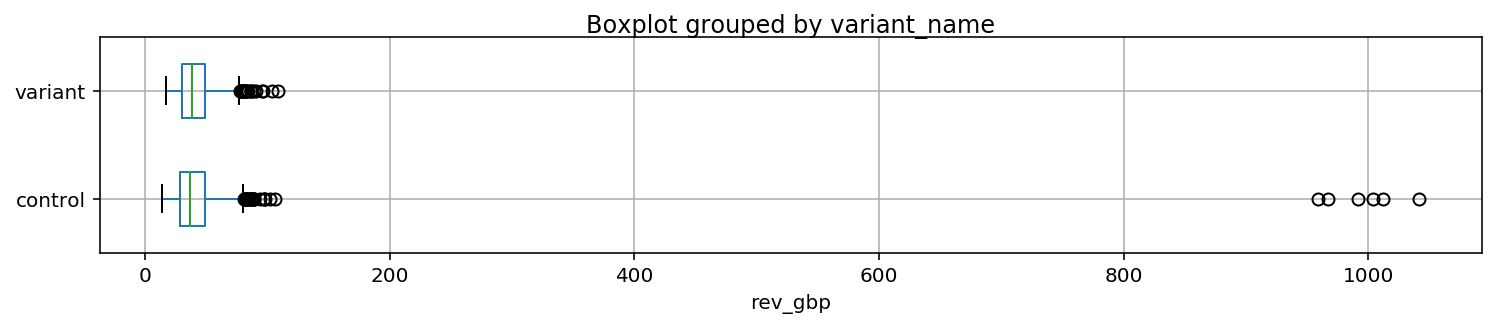

In [5]:
# quickly checking the distribuion
ax = rev_data.boxplot('rev_gbp', by='variant_name', figsize=(12, 2), widths=(0.5, 0.5), vert=False)
ax.set_xlabel('rev_gbp')
ax.set_title('')

rev_data.groupby('variant_name')['rev_gbp'].describe(percentiles=[.01, 0.05, .25, .50, .75, .95, .99]).round(1)

In [7]:
outlier_threshold = 900

print('The volume ratio')
print(rev_data.query('rev_gbp >= @outlier_threshold').groupby('variant_name')['rev_gbp'].sum())

The volume ratio
variant_name
control    5974.9425
Name: rev_gbp, dtype: float64


In [8]:
# checking individual outliers
outlier_threshold = rev_data.query('variant_name == "control"')['rev_gbp'].quantile(0.99)
print(rev_data.query('rev_gbp >= @outlier_threshold').sort_values(by='rev_gbp', ascending=False).head(10))
print()

outlier_threshold_2 = 900
print('The count ratio')
print(rev_data.query('rev_gbp >= @outlier_threshold_2').groupby('variant_name')['rev_gbp'].count() / 
      rev_data.groupby('variant_name')['rev_gbp'].count())
print()

print('The volume ratio')
print(rev_data.query('rev_gbp >= @outlier_threshold_2').groupby('variant_name')['rev_gbp'].sum() / 
      rev_data.groupby('variant_name')['rev_gbp'].sum())

      user_id      rev_gbp variant_name
1568   101006  1041.541400      control
1626   101003  1011.664000      control
66     101007  1004.261800      control
559    101005   991.294100      control
1490   101008   966.966300      control
1631   101004   959.214900      control
1589   101481   108.830636      variant
451    100968   105.865227      control
899    101998   103.437548      variant
292    100288   101.780293      control

The count ratio
variant_name
control    0.005676
variant         NaN
Name: rev_gbp, dtype: float64

The volume ratio
variant_name
control    0.124242
variant         NaN
Name: rev_gbp, dtype: float64


There are six outliers, with rev_gbp > 900, all of them are in the control group. The values are so extreme that they probably need to be explained separately. For the time being, let's take a note that they are 0.6% of all cases, however they account for 12.4% of the total revenue so these few cases seem to be important from the revenue point of view.

They do not appear for the alternative scenario therefore it is worth investigating whether the alternative scenario has eliminated them for some reason i.e. did not allow customers to choose very long drives or luxiry drives.

Let's exclude these outliers from the subsequent analysis as they may greatly influence to the distribution of typical cases.

In [9]:
# reduced data set
rev_data_2 = rev_data.query('rev_gbp < @outlier_threshold_2').copy()

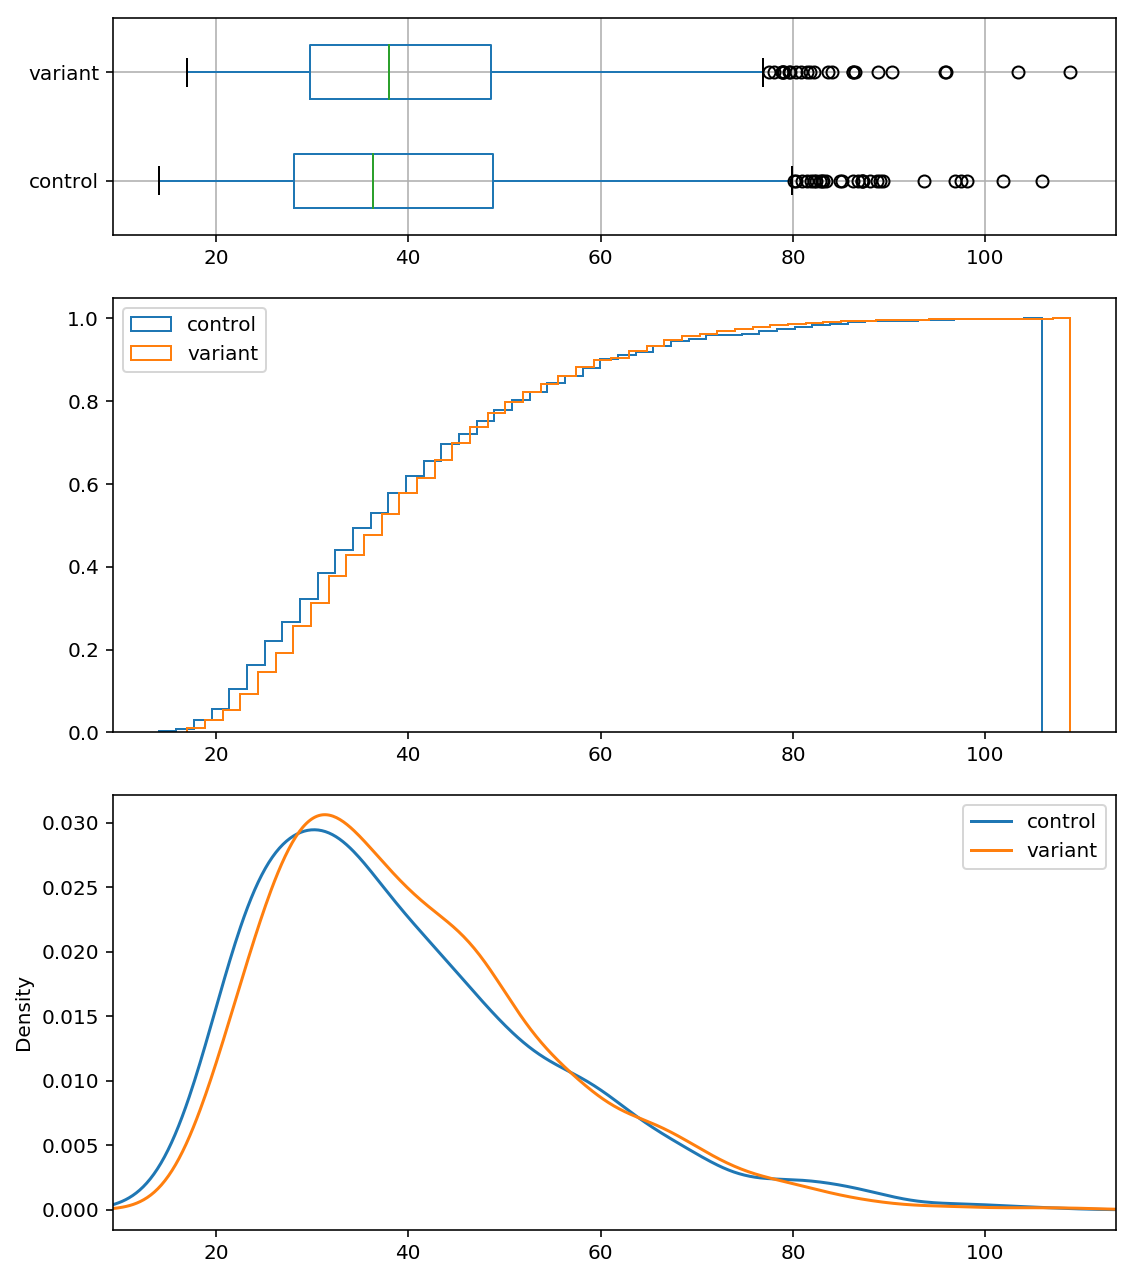

In [10]:
# just drawing distributions for both the scenarios

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 9))
grid = plt.GridSpec(nrows=3, ncols=1, height_ratios=[1,2,2])

ax = plt.subplot(grid[0, 0])
rev_data_2.boxplot('rev_gbp', by='variant_name', widths=(0.5, 0.5), vert=False, ax=ax)
fig.suptitle('')
ax.set_title('')
ax.set_xlabel('')
xlim = ax.get_xlim()

ax = plt.subplot(grid[1, 0])
bins = ax.hist(rev_data_2.query('variant_name == "control"')['rev_gbp'], cumulative=True, density=True, histtype='step', bins=50)
bins = ax.hist(rev_data_2.query('variant_name == "variant"')['rev_gbp'], cumulative=True, density=True, histtype='step', bins=50)
ax.legend(['control', 'variant'], loc='upper left')
ax.set_xlim(xlim)

ax = plt.subplot(grid[2, 0])
rev_data_2.query('variant_name == "control"')[['rev_gbp']].plot.kde(ax=ax)
rev_data_2.query('variant_name == "variant"')[['rev_gbp']].plot.kde(ax=ax)
ax.legend(['control', 'variant'])
ax.set_xlim(xlim)

fig.tight_layout()

Visually, the 'variant' case promises slightly larger mean value. But, let's test it statistically under the null hypothesis that the mean revenue is the same for both the cases. There can be different approaches to it, I'll take a simple one with the Mann-Whitney non-parametrical test.

In [11]:
## Mann-Whitney Test

In [17]:
# storing the values for the cases in individual variables to make it easier to access the data
X_control = rev_data_2.query('variant_name == "control"')['rev_gbp']
X_variant = rev_data_2.query('variant_name == "variant"')['rev_gbp']

In [18]:
scipy.stats.mannwhitneyu(X_control, X_variant, alternative='less')

MannwhitneyuResult(statistic=525121.0, pvalue=0.017928857284127575)

The test statistics' value is relatively low (0.018), it does not support the null hypothesis at the significance level of 0.05 the null hypothesis should not be accepted, it's rejected.

Ideas:
- we can conduct a bootstrap testing under the same null hypothesis to check if the result will be consistent with the above.

## Conclusion

The 'variant' scenario provides greater mean of revenue (thus, more revenue in total), this is statistically significant (at the level $\alpha$=0.05). Practically-wise, it is a bit more complicated because there are six outliers in the control group which account for 12.4% of the total revenue. If they are typical for the 'control' scenario but excluded in the 'variant' case, the total revenue might be smaller in the 'variant' case in the long-run term.

The recommendations are
- to explain what the extremely high values 'rev_gbp' in the control group are, whether they are typical under certain circumstances,
- to keep the 'variant' scenario but ensure it allows for the exteremly high values (see above) if they are not random.

# Exercise 5

>You are given a dataset that consists of approximately 3000 customer reviews (input text), ratings, date of the review (see ex5 file). You need to build a model to predict the sentiment of the review (positive or negative). We consider ratings 4 and 5 as a positive review, all other ratings are negative. Please include your work in the Jupyter notebook with the analysis of this data, training and testing of the model. Also, at the end of your analysis, could you briefly describe the steps you would take in order to release the model on production.

In [19]:
rating = pd.read_csv('ex5.csv')

In [20]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 4 columns):
rating              3150 non-null int64
date                3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(2)
memory usage: 98.6+ KB


## EDA and Data Normalization

In [21]:
# tidying up types
rating['date'] = pd.to_datetime(rating['date'])
rating['feedback'] = rating['feedback'].astype('category')

In [22]:
rating['rating'].value_counts().sort_index()

1     161
2      96
3     152
4     455
5    2286
Name: rating, dtype: int64

In [23]:
rating['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [24]:
rating_over_time = rating.groupby(['date', 'feedback'])['feedback'].agg('count').unstack()

date_range = pd.date_range(rating['date'].min(), rating['date'].max(), freq='1d')
rating_over_time = rating_over_time.reindex(date_range).fillna(0).astype('int')

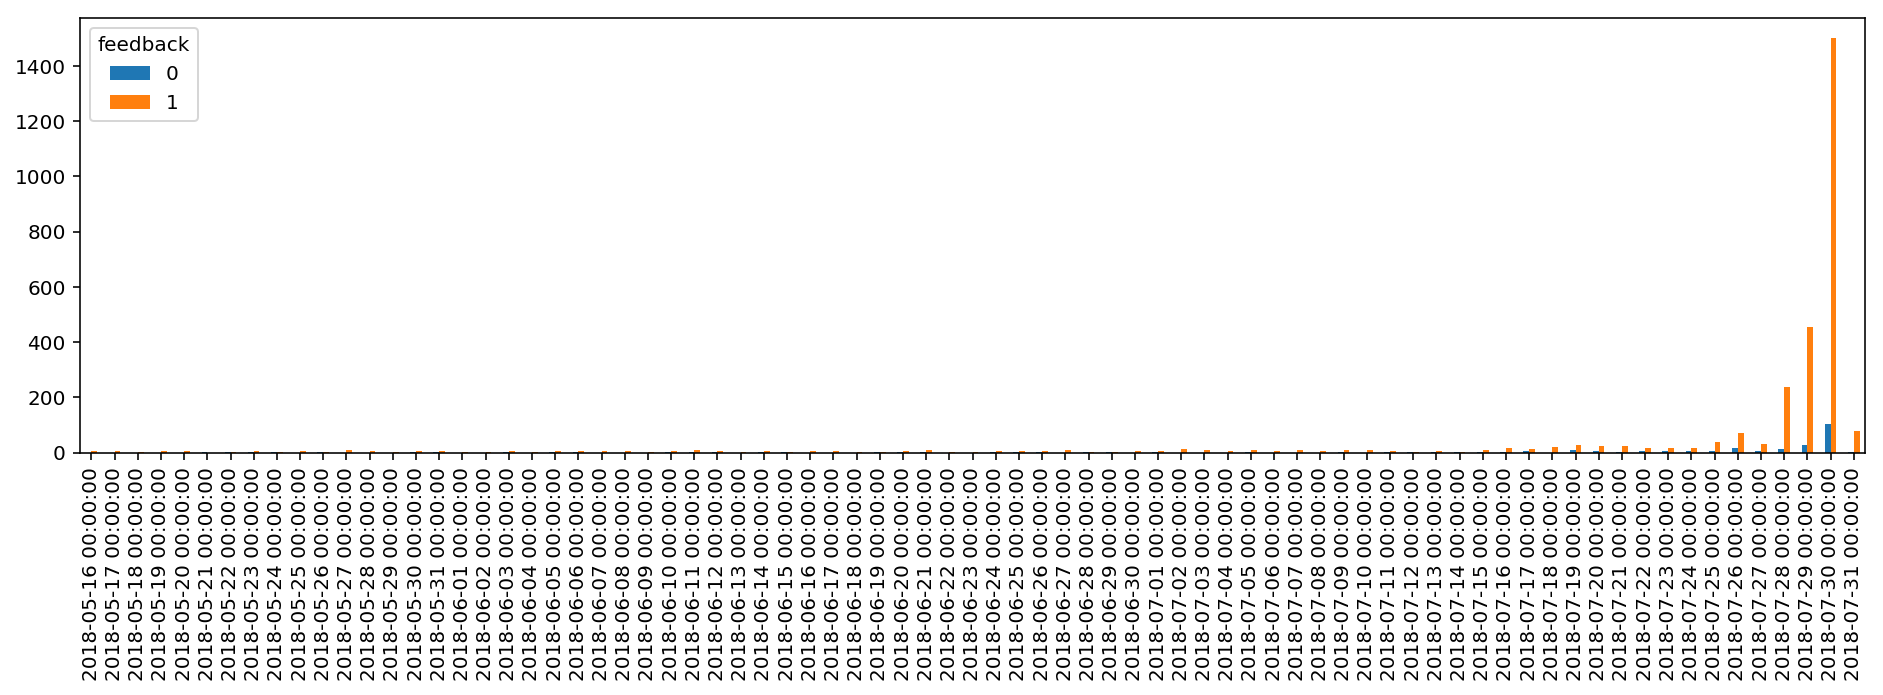

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

_ = rating_over_time.plot.bar(ax=ax)

In [26]:
rating['verified_reviews'].sample(10)

890                                   Works as advertised
3010    Sound is terrible. Cannot pair with echo to pl...
2568    very handy in the kitchen, sets timer and give...
1364    It's not as good as Siri, BUT it still has som...
226                                           plays great
195                                   Works as advertised
2074    Didn’t really work as smooth as they make it s...
841     I have had Alexa since the beginning.  I accid...
2961                            I love how compact it is.
2470    I have had the echo dot for about two weeks an...
Name: verified_reviews, dtype: object

**Conclusion following EDA**:
1. The review language is English.
2. There are ~11 times more positive reviews than negative ones so the classes are not balanced.
3. The reviews are not spread equally over the time. Over the span of two months and the half, most of the feedbacks were placed in the last few days, that's true for both the negative and positive feedbacks.

## NL-data Preprocessing

In [27]:
import nltk

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer

In [28]:
import string

lemmatizer = WordNetLemmatizer() 

def normalize_review(review, stop_words=None):
    
    # tokenizing
    words = word_tokenize(review)
    
    # remove any punctuation and digits
    words = list(set(words).difference(set(string.punctuation+string.digits)))
    
    words = [word.lower() for word in words]
    
    # removing stop words
    if stop_words is not None:
        words = list(set(words).difference(stop_words))
        
    word_list = [lemmatizer.lemmatize(word, pos="v") for word in words]
    #words = ' '.join(word_list)
        
    return word_list

In [29]:
stop_words = set(stopwords.words('english'))

rating['normalized_review_list'] = rating['verified_reviews'].apply(lambda x: normalize_review(x, stop_words))
rating['normalized_review_len'] = rating['normalized_review_list'].apply(lambda x: len(x))
rating['normalized_review'] = rating['normalized_review_list'].apply(lambda x: ' '.join(x))

In [30]:
print('Number of reviews without any normalized text: {}'.format((rating['normalized_review_len'] == 0).sum()))

# filling in reviews which have become empty after the normalization
rating.loc[rating['normalized_review_len'] == 0, 'normalized_review'] = '*NaT*'

# TBC: investigate why the normalization have depleted some reviews
print(rating.query('normalized_review_len == 0')[['verified_reviews', 'normalized_review', 'feedback']].sample(10))

Number of reviews without any normalized text: 79
     verified_reviews normalized_review feedback
2861                              *NaT*        1
3123                              *NaT*        1
1094                              *NaT*        0
3126                              *NaT*        1
2732                              *NaT*        1
183                               *NaT*        1
2104                              *NaT*        1
780                               *NaT*        1
2662                              *NaT*        1
2628                              *NaT*        0


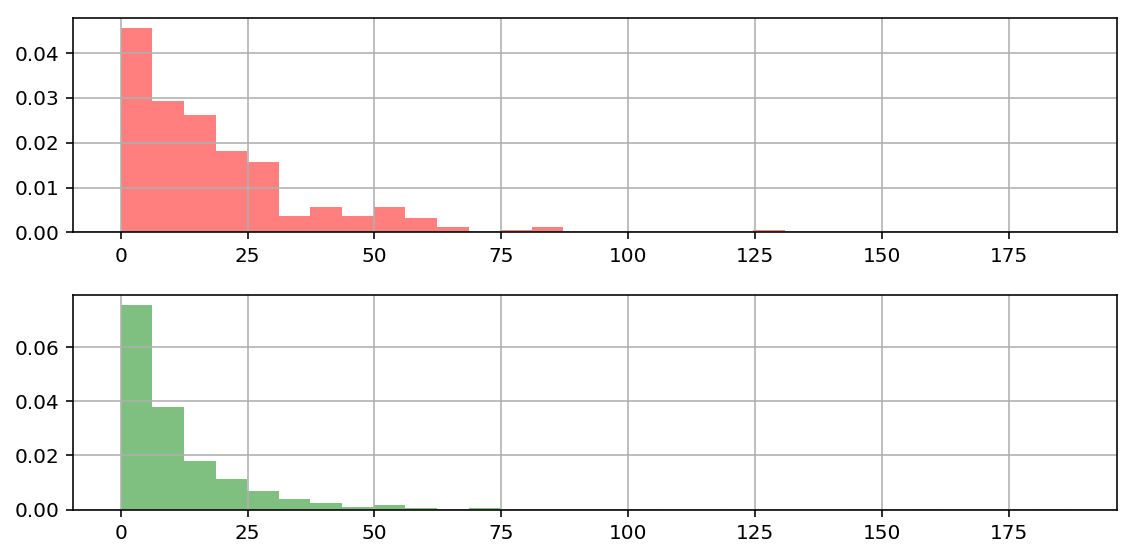

In [31]:
# distribution of the number of words
fig, axs = plt.subplots(2, 1, figsize=(8, 4))

max_len = rating['normalized_review_len'].max()

ax = axs[0]
rating.query('feedback == 0')['normalized_review_len'].hist(ax=ax, bins=30, alpha=0.5, color='red', density=True, range=[0, max_len])
ax = axs[1]
rating.query('feedback == 1')['normalized_review_len'].hist(ax=ax, bins=30, alpha=0.5, color='green', density=True, range=[0, max_len])

fig.tight_layout()

In [32]:
#import itertools
#review_corpus = list(itertools.chain.from_iterable(rating['normalized_review_list'].to_list()))
#print(len(review_corpus))

In [33]:
# out of curiosity, just checking what words are mostly associated with 'alexa'

import gensim

model = gensim.models.Word2Vec(rating['normalized_review_list'],
                               min_count=1, size=50, window=5, workers=4)

model.wv.most_similar('alexa', topn=5)

[('show', 0.999915361404419),
 ('house', 0.9999105334281921),
 ('get', 0.9999080896377563),
 ('look', 0.9999061226844788),
 ('play', 0.9999045133590698)]

In [34]:
cv = CountVectorizer(binary=True)
X = cv.fit_transform(rating['normalized_review'])
X

<3150x3263 sparse matrix of type '<class 'numpy.int64'>'
	with 35992 stored elements in Compressed Sparse Row format>

In [35]:
y = rating['feedback'].astype('int')

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

c_values = np.logspace(-2, 2, 50)

logit_cv_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, scoring='roc_auc', verbose=1, n_jobs=4, random_state=42)
logit_cv_searcher.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01, 2.94705170e-01, 3.55648031e-01,
       4.29193426e-01, 5.17...
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn', n_jobs=4,
                     penalty='l2', random_state=42, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

The optimal C=0.63


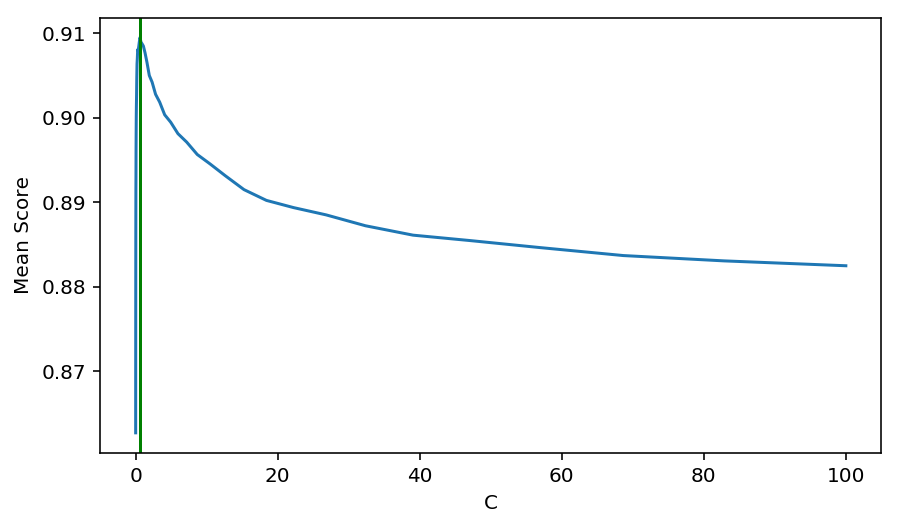

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(c_values, np.mean(logit_cv_searcher.scores_[1], axis=0))
ax.set_xlabel('C')
ax.set_ylabel('Mean Score')
ax.axvline(logit_cv_searcher.C_, 0, 1, color='green')
print('The optimal C={:.2f}'.format(logit_cv_searcher.C_[0]))

In [39]:
# scoring the model on the test data

y_hat = logit_cv_searcher.predict(X_test)

metrics.roc_auc_score(y_test, y_hat)

0.6075094260578132

**Conclusion**

We took a basic approach with verctorizing feedbacks and using Logistic Regression to predict the class of feedback. The AUC score is not great so probably need to investigate into better approaches (other ways of representing feedbacks numerically (word2vec&), other models etc).

## DL with Embeddings

In [40]:
# TBC

## Consideration on Deployment

The libraries used to build the model(s) allow to 'externalize' it by saving its to a file. Later on, it can be loaded from the file and used for getting predictions. Somehow, it needs to be possible to place a call for getting those predictions. The most universal way to do that seems to place that call as a web service call. With that in mind, the typical deployment model for this case might be
- define a container with all necessary prerequisites including libraries for running a web service (Flask is popular here),
- develop code (to live within a container) which receives am external web service call, pass it to a model, get results from a model and return the results as the web service call's response.
- configure the container deployment with DevOps pipeline,
- deploy according to DevOps pipeline.